# VAE-aa
https://arxiv.org/abs/2002.00815

Learning Extremal Representations with Deep Archetypal Analysis


The following plots aggregate the GPU results saved from multiple K and
seed configurations to determine the optimal K.

calculate the NMI, consistency, and loss of the identified AA archetypes to determine the optimal number of K.

K=2: NMI=0.6551±0.0622 | CONS=-149.1178±19.4377 | LOSS(mean)=10.4652±0.2594 | LOSS(seed42)=10.5245
K=3: NMI=0.6448±0.0930 | CONS=-137.5043±16.1204 | LOSS(mean)=10.4463±0.2363 | LOSS(seed42)=10.3545
K=4: NMI=0.7001±0.0533 | CONS=-141.8047±7.9012 | LOSS(mean)=10.2984±0.2340 | LOSS(seed42)=10.2947
K=5: NMI=0.7803±0.0852 | CONS=-123.2870±14.9452 | LOSS(mean)=10.7794±1.1191 | LOSS(seed42)=10.2931
K=6: NMI=0.7409±0.1193 | CONS=-137.5988±9.4198 | LOSS(mean)=10.1878±0.2017 | LOSS(seed42)=10.4929
K=7: NMI=0.7755±0.0700 | CONS=-136.5115±10.7093 | LOSS(mean)=10.4103±0.4635 | LOSS(seed42)=9.9361


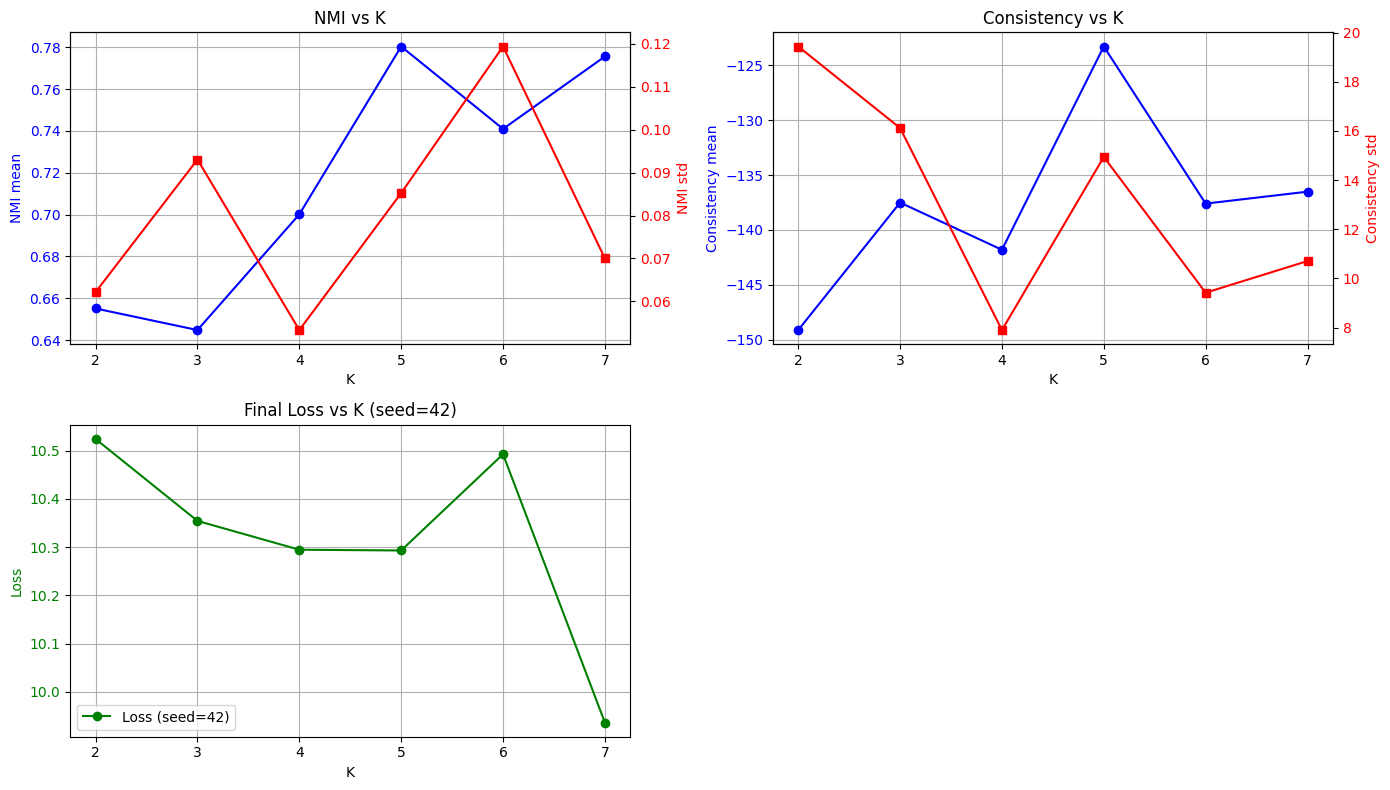

In [ ]:
import os
import numpy as np
import pickle
from utils.metrics import calcNMI, ArchetypeConsistency
import matplotlib.pyplot as plt

# ==============================
# Configuration
# ==============================
BASE = "results/kmnist"     # Change here if you want to use MNIST instead
SEEDS = [42, 43, 44, 45, 46]
K_LIST = list(range(2, 8))
TARGET_SEED = 42  # Use only seed 42 for the loss plot

# ==============================
# Helper functions
# ==============================
def load_AA(folder):
    """Load final_archetypes_decoded.npy and flatten for comparison."""
    p = os.path.join(folder, "final_archetypes_decoded.npy")
    if not os.path.exists(p):
        return None, None
    A = np.load(p)
    A_flat = A.reshape(A.shape[0], -1)
    return A_flat, A_flat.T

def load_loss(folder):
    """Load the last epoch total loss from epoch_total_losses.pkl."""
    p = os.path.join(folder, "epoch_total_losses.pkl")
    if not os.path.exists(p):
        return None
    with open(p, "rb") as f:
        loss_list = pickle.load(f)
    return float(loss_list[-1])

# ==============================
# Metric computation
# ==============================
results = {}
seed42_losses = []  # store loss of seed 42 for each K

for k in K_LIST:
    nmi_vals, cons_vals, loss_vals = [], [], []
    mats = {}

    for s in SEEDS:
        folder = os.path.join(BASE, f"seed_{s}_aa_{k}")
        A_flat, A_T = load_AA(folder)
        loss = load_loss(folder)

        if A_flat is not None and loss is not None:
            mats[s] = (A_flat, A_T, loss)
            loss_vals.append(loss)
            if s == TARGET_SEED:
                seed42_losses.append(loss)

    # Compute pairwise NMI and consistency
    keys = list(mats.keys())
    for i in range(len(keys)):
        for j in range(i + 1, len(keys)):
            A_flat, A_T, _ = mats[keys[i]]
            B_flat, B_T, _ = mats[keys[j]]

            nmi = calcNMI(A_flat, B_flat)
            cons, _ = ArchetypeConsistency(A_T, B_T, mSST=1.0)  # ISI ignored

            nmi_vals.append(nmi)
            cons_vals.append(cons)

    results[k] = {
        "nmi_mean": np.mean(nmi_vals),
        "nmi_std": np.std(nmi_vals),
        "cons_mean": np.mean(cons_vals),
        "cons_std": np.std(cons_vals),
        "loss_mean": np.mean(loss_vals),
        "loss_std": np.std(loss_vals)
    }

# ==============================
# Print summary table
# ==============================
for k in K_LIST:
    r = results[k]
    print(
        f"K={k}: "
        f"NMI={r['nmi_mean']:.4f}±{r['nmi_std']:.4f} | "
        f"CONS={r['cons_mean']:.4f}±{r['cons_std']:.4f} | "
        f"LOSS(mean)={r['loss_mean']:.4f}±{r['loss_std']:.4f} | "
        f"LOSS(seed{TARGET_SEED})={seed42_losses[K_LIST.index(k)]:.4f}"
    )

# ==============================
# Plot results (2×2 layout: Loss on 2nd row)
# ==============================
K = np.array(K_LIST)

# Extract data
nmi_mean = np.array([results[k]["nmi_mean"] for k in K_LIST])
nmi_std  = np.array([results[k]["nmi_std"]  for k in K_LIST])
cons_mean = np.array([results[k]["cons_mean"] for k in K_LIST])
cons_std  = np.array([results[k]["cons_std"]  for k in K_LIST])
loss_seed42 = np.array(seed42_losses)  # only seed 42 loss

# 2 rows × 2 columns (Loss centered on the second row)
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
ax1, ax2 = axes[0]
ax3 = axes[1, 0]
axes[1, 1].axis("off")  # hide empty plot

# ---------------------- Plot 1: NMI ----------------------
ax1.plot(K, nmi_mean, marker='o', color='blue', label="NMI mean")
ax1.set_xlabel("K")
ax1.set_ylabel("NMI mean", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("NMI vs K")
ax1.grid(True)

# Plot NMI std on secondary axis
ax1r = ax1.twinx()
ax1r.plot(K, nmi_std, marker='s', color='red', label="NMI std")
ax1r.set_ylabel("NMI std", color='red')
ax1r.tick_params(axis='y', labelcolor='red')

# ---------------------- Plot 2: Consistency ----------------------
ax2.plot(K, cons_mean, marker='o', color='blue', label="Consistency mean")
ax2.set_xlabel("K")
ax2.set_ylabel("Consistency mean", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_title("Consistency vs K")
ax2.grid(True)

# Plot Consistency std on secondary axis
ax2r = ax2.twinx()
ax2r.plot(K, cons_std, marker='s', color='red', label="Consistency std")
ax2r.set_ylabel("Consistency std", color='red')
ax2r.tick_params(axis='y', labelcolor='red')

# ---------------------- Plot 3: Loss (Second row, left) ----------------------
ax3.plot(K, loss_seed42, marker='o', color='green', label=f"Loss (seed={TARGET_SEED})")
ax3.set_xlabel("K")
ax3.set_ylabel("Loss", color='green')
ax3.tick_params(axis='y', labelcolor='green')
ax3.set_title(f"Final Loss vs K (seed={TARGET_SEED})")
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()


In [ ]:
# ============================================
# seed=42, K=5, epoch=50
# ============================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import random, numpy as np, os, json, pickle
from sklearn.cluster import KMeans


# -----------------------------
config = {
    "dataset": "kmnist",  
    "batch_size": 500,
    "max_epochs": 100,
    "latent_dim": 32,
    "lr": 0.005,
    "train_subset_size": 20000,
    "warmup_epochs": 5,
    "semantic_epochs": 10,
    "nu_x_tilde": 200,
    "gamma": 200,
    "beta": 0.01,
    "alpha": 0.1,
    "cos_sim_weight": 1.0,
    "num_classes": 10,
    "num_archetypes_per_class": 5,
    "total_archetypes": 50,
    "SEED": 42,
    "exp_dir": "./results/kmnist_notebook_seed42_aa5"  
}

os.makedirs(config["exp_dir"], exist_ok=True)


def set_seed(s):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(config["SEED"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Init] Using device: {device}")

# -----------------------------
transform = transforms.Compose([transforms.ToTensor()])
if config["dataset"] == "kmnist":
    full_train_set = datasets.KMNIST("./data", train=True, download=True, transform=transform)  
    test_set = datasets.KMNIST("./data", train=False, download=True, transform=transform)        
else:
    raise ValueError("Only KMNIST supported for this version")

train_loader_full = DataLoader(full_train_set, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_set, batch_size=config["batch_size"], shuffle=False)

def prepare_class_full_data(dataset, device):
    class_full_imgs = {}
    for img, label in dataset:
        label = int(label)
        if label not in class_full_imgs:
            class_full_imgs[label] = []
        class_full_imgs[label].append(img.unsqueeze(0))
    for label in class_full_imgs:
        class_full_imgs[label] = torch.cat(class_full_imgs[label]).to(device)
    return class_full_imgs

class_full_imgs = prepare_class_full_data(full_train_set, device)

# -----------------------------
class VAEWithAA(nn.Module):
    def __init__(self, latent_dim=32, img_channels=1, img_size=28, num_classes=10):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Flatten(),
            nn.Linear(7 * 7 * 64, 512), nn.ReLU(),
            nn.Linear(512, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512), nn.ReLU(),
            nn.Linear(512, 7 * 7 * 64),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(), nn.Linear(128, num_classes)
        )
        self.arch_logits = nn.ParameterDict()
        self.class_full_mu = {}
        self.fc_sample_to_aa = nn.Linear(latent_dim, config["total_archetypes"])

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        mu = mu / (mu.norm(dim=1, keepdim=True) + 1e-8)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def init_class_archetypes(self, class_full_imgs, device):
        print("[Init] Initializing class-wise archetypes (multi-seed + fallback)...")
        for label, imgs in class_full_imgs.items():
            mu, _ = self.encode(imgs)
            self.class_full_mu[label] = mu.detach()
            mu_np = mu.detach().cpu().numpy()
            target_num = config["num_archetypes_per_class"]

            centers_np = None
            for seed_offset in range(5):
                try_seed = config["SEED"] + seed_offset
                km = KMeans(n_clusters=target_num, random_state=try_seed, n_init=10, max_iter=300).fit(mu_np)
                centers_np = km.cluster_centers_
                break

            centers = torch.tensor(centers_np, device=device, dtype=mu.dtype)
            dists = torch.cdist(centers, mu)
            idx = dists.topk(k=20, largest=False).indices
            logits = torch.zeros(target_num, mu.size(0), device=device)
            for i in range(target_num):
                logits[i, idx[i]] = 5.0
            self.arch_logits[str(label)] = nn.Parameter(logits, requires_grad=True)
        print("[Init] Archetypes initialized.")

    def get_all_archetypes(self):
        all_arch = []
        for label in sorted(self.arch_logits.keys()):
            W = F.softmax(self.arch_logits[label], dim=1)
            X_mu_full = self.class_full_mu[int(label)]
            all_arch.append(W @ X_mu_full)
        return torch.cat(all_arch, dim=0)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        sample_to_aa_weights = F.softmax(self.fc_sample_to_aa(mu), dim=1)
        x_hat = self.decode(z)
        return x_hat, z, mu, logvar, sample_to_aa_weights

# -----------------------------
def kl_loss(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

def recon_loss(x_hat, x):
    return F.mse_loss(x_hat, x, reduction='mean')

def estimate_mutual_info_ty(mu, classifier, num_classes=10):
    logits = classifier(mu)
    probs = F.softmax(logits, dim=1)
    entropy_cond = -torch.sum(probs * torch.log(probs + 1e-8), dim=1).mean()
    return -entropy_cond

def cos_similarity_loss(mu_batch, all_archetypes, weights_batch):
    recon_sample = torch.matmul(weights_batch, all_archetypes)
    cos_sim = F.cosine_similarity(recon_sample, mu_batch, dim=1).mean()
    return (1 - cos_sim)

def total_aa_loss(model, mu):
    all_archetypes = model.get_all_archetypes()
    weights_batch = F.softmax(model.fc_sample_to_aa(mu), dim=1)
    loss_sample = F.mse_loss(torch.matmul(weights_batch, all_archetypes), mu)
    loss_cos = cos_similarity_loss(mu, all_archetypes, weights_batch)
    total_loss = loss_sample + config["cos_sim_weight"] * loss_cos
    return total_loss, loss_sample.item(), loss_cos.item()

# -----------------------------
model = VAEWithAA(latent_dim=config["latent_dim"]).to(device)
optimizer = torch.optim.Adam([{"params": model.parameters(), "lr": config["lr"]}])
epoch_losses = []

print(f"[Training Start] {config['max_epochs']} epochs total")
print(f"Warmup: first {config['warmup_epochs']} epochs | Semantic: {config['warmup_epochs']+1}–{config['semantic_epochs']} | AA starts from {config['semantic_epochs']+1}")
print(f"[Config] batch_size={config['batch_size']} | lr={config['lr']} | gamma={config['gamma']} | cos_sim_weight={config['cos_sim_weight']}\n")

for epoch in range(config["max_epochs"]):
    print(f"===================== Epoch {epoch+1}/{config['max_epochs']} =====================")
    if epoch < config["warmup_epochs"]:
        print("Mode: Warmup (KL + Reconstruction)")
    elif epoch < config["semantic_epochs"]:
        print("Mode: Semantic (KL + Recon + weak MI)")
    else:
        print("Mode: Full (KL + Recon + MI + full AA reconstruction + cos loss)")

    rand_idx = random.sample(range(len(full_train_set)), config["train_subset_size"])
    train_subset = Subset(full_train_set, rand_idx)
    train_loader = DataLoader(train_subset, batch_size=config["batch_size"], shuffle=True)
    
    if epoch == config["semantic_epochs"]:
        model.init_class_archetypes(class_full_imgs, device)
        for p in model.arch_logits.parameters():
            p.requires_grad = True
        optimizer.add_param_group({"params": model.arch_logits.parameters(), "lr": 1e-2})

    total_loss_sum, total_samples = 0, 0
    model.train()
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        x_hat, z, mu, logvar, sample_to_aa = model(x)

        I_tx = kl_loss(mu, logvar)
        recon = recon_loss(x_hat, x)
        I_ty_raw = estimate_mutual_info_ty(mu, model.classifier, config["num_classes"])
        I_ty_display = -I_ty_raw

        if epoch >= config["semantic_epochs"]:
            L_at, avg_Ls, avg_La = total_aa_loss(model, mu)
        else:
            L_at, avg_Ls, avg_La = torch.tensor(0.0).to(device), 0.0, 0.0

        if epoch < config["warmup_epochs"]:
            total_loss = I_tx + config["nu_x_tilde"] * recon
        elif epoch < config["semantic_epochs"]:
            total_loss = I_tx - (config["beta"] * 0.5) * I_ty_raw + config["nu_x_tilde"] * recon
        else:
            total_loss = I_tx - config["beta"] * I_ty_raw + config["nu_x_tilde"] * recon + config["gamma"] * L_at

        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        bs = x.size(0)
        total_loss_sum += total_loss.item() * bs
        total_samples += bs

        if (batch_idx + 1) % 10 == 0:
            print(f"[Train] Batch {batch_idx+1:03d} | I(t;x): {I_tx.item():.4f} | I(t;y): {I_ty_display.item():.4f} | Recon: {recon.item():.4f} | Total: {total_loss.item():.4f}")
            if epoch >= config["semantic_epochs"]:
                print(f"   ↳ AA sample loss: {avg_Ls:.6f} | AA cos loss: {avg_La:.6f}")

    avg_loss = total_loss_sum / total_samples
    epoch_losses.append(avg_loss)
    print(f"\n[Summary] Epoch {epoch+1} Train Total Loss: {avg_loss:.4f}")
    print("=======================================================================\n")

# -----------------------------

loss_path = os.path.join(config["exp_dir"], "epoch_total_losses.pkl")
with open(loss_path, "wb") as f:
    pickle.dump(epoch_losses, f)
print(f"[Save] Epoch losses saved to: {loss_path}")

if hasattr(model, "get_all_archetypes"):
    all_arch = model.get_all_archetypes().cpu().detach().numpy()
    aa_path = os.path.join(config["exp_dir"], "final_archetypes.npy")
    np.save(aa_path, all_arch)
    decoded = model.decode(torch.tensor(all_arch, device=device)).cpu().detach().numpy()
    np.save(os.path.join(config["exp_dir"], "final_archetypes_decoded.npy"), decoded)
    print(f"[Save] Archetypes & decoded saved in: {config['exp_dir']}")

torch.save(model.state_dict(), os.path.join(config["exp_dir"], "model_final.pth"))
print(f"[Save] Final model saved to: {config['exp_dir']}")

torch.save(model, os.path.join(config["exp_dir"], "model_full.pth"))
print(f"[Save] Full model (with archetypes & AA mapping) saved to: {config['exp_dir']}")

# ============================================

print("\n[PostProcess] Saving full latent reconstruction results (correct AA reconstruction) ...")

full_loader = DataLoader(full_train_set, batch_size=config["batch_size"], shuffle=False)

model.eval()
all_mu, all_mu_aa, all_decoded_mu, all_decoded_mu_aa, all_mse = [], [], [], [], []

with torch.no_grad():
    all_archetypes = model.get_all_archetypes().to(device)

    for x, _ in full_loader:
        x = x.to(device)
        mu, _ = model.encode(x)

        weights = F.softmax(model.fc_sample_to_aa(mu), dim=1)
        mu_aa = weights @ all_archetypes

        decoded_mu = model.decode(mu)
        decoded_mu_aa = model.decode(mu_aa)

        mse = F.mse_loss(decoded_mu_aa, x, reduction="none").mean(dim=[1, 2, 3])

        all_mu.append(mu.cpu())
        all_mu_aa.append(mu_aa.cpu())
        all_decoded_mu.append(decoded_mu.cpu())
        all_decoded_mu_aa.append(decoded_mu_aa.cpu())
        all_mse.append(mse.cpu())

all_mu = torch.cat(all_mu)
all_mu_aa = torch.cat(all_mu_aa)
all_decoded_mu = torch.cat(all_decoded_mu)
all_decoded_mu_aa = torch.cat(all_decoded_mu_aa)
all_mse = torch.cat(all_mse)

np.save(os.path.join(config["exp_dir"], "latent_mu.npy"), all_mu.numpy())
np.save(os.path.join(config["exp_dir"], "latent_mu_AA.npy"), all_mu_aa.numpy())
np.save(os.path.join(config["exp_dir"], "decoded_mu.npy"), all_decoded_mu.numpy())
np.save(os.path.join(config["exp_dir"], "decoded_mu_AA.npy"), all_decoded_mu_aa.numpy())
np.save(os.path.join(config["exp_dir"], "reconstruction_mse.npy"), all_mse.numpy())

mean_mse = all_mse.mean().item()
with open(os.path.join(config["exp_dir"], "reconstruction_mse_mean.txt"), "w") as f:
    f.write(f"Average MSE (AA reconstruction): {mean_mse:.6f}\n")

print(f"[Done] AA reconstruction results saved to: {config['exp_dir']}")
print(f"Average AA reconstruction MSE = {mean_mse:.6f}")

[Init] Using device: cpu
[Training Start] 100 epochs total
Warmup: first 5 epochs | Semantic: 6–10 | AA starts from 11
[Config] batch_size=500 | lr=0.005 | gamma=200 | cos_sim_weight=1.0

===================== Epoch 1/100 =====================
Mode: Warmup (KL + Reconstruction)
[Train] Batch 010 | I(t;x): 0.5615 | I(t;y): 2.2996 | Recon: 0.1068 | Total: 21.9270
[Train] Batch 020 | I(t;x): 0.5387 | I(t;y): 2.3004 | Recon: 0.0962 | Total: 19.7709
[Train] Batch 030 | I(t;x): 0.6749 | I(t;y): 2.3002 | Recon: 0.0914 | Total: 18.9506
[Train] Batch 040 | I(t;x): 1.0343 | I(t;y): 2.3003 | Recon: 0.0851 | Total: 18.0471

[Summary] Epoch 1 Train Total Loss: 21.8139

===================== Epoch 2/100 =====================
Mode: Warmup (KL + Reconstruction)
[Train] Batch 010 | I(t;x): 1.2846 | I(t;y): 2.3004 | Recon: 0.0783 | Total: 16.9545
[Train] Batch 020 | I(t;x): 1.2062 | I(t;y): 2.3004 | Recon: 0.0750 | Total: 16.1986
[Train] Batch 030 | I(t;x): 1.3077 | I(t;y): 2.3005 | Recon: 0.0699 | Tota

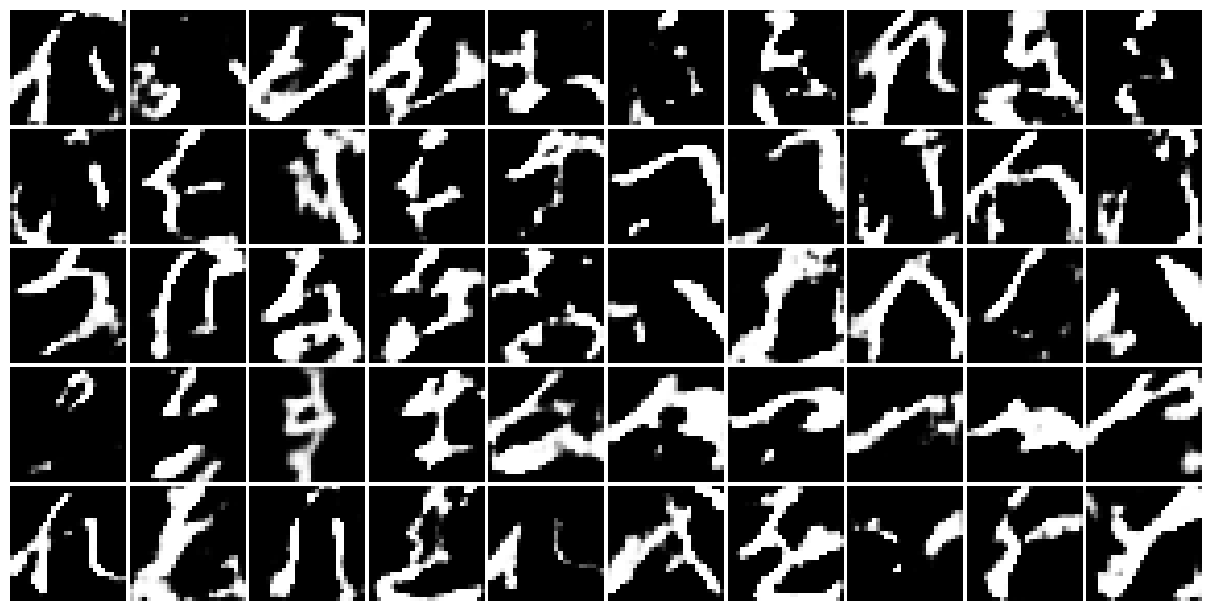

In [ ]:
from utils.visualization import plot_decoded_archetypes
plot_decoded_archetypes("results/kmnist_notebook_seed42_aa5")

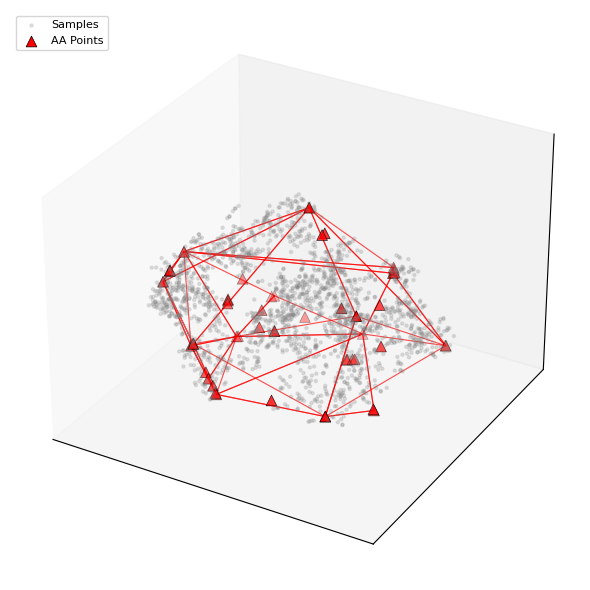

In [ ]:
from utils.visualization import visualize_latent_archetypes_3d

visualize_latent_archetypes_3d(
    exp_dir="results/kmnist_notebook_seed42_aa5",
    dataset="kmnist",
    latent_dim=32,
    seed=42
)


In [ ]:

import numpy as np
import torch
from torchvision import datasets, transforms
import os

def evaluate_saved_train_reconstruction(exp_dir="./results/kmnist_notebook_seed42_aa5", dataset="kmnist"):
    """
    Using the saved decoded_mu.npy and decoded_mu_AA.npy,
    directly compute the per-class reconstruction MSE for AE vs. AA
    (compatible with both VAE and AE models).
    The output format matches the training log.
    """
    transform = transforms.Compose([transforms.ToTensor()])
    if dataset == "mnist":
        ds_train = datasets.MNIST("./data", train=True, transform=transform, download=True)
    elif dataset == "kmnist":
        ds_train = datasets.KMNIST("./data", train=True, transform=transform, download=True)
    else:
        raise ValueError("dataset 仅支持 mnist/kmnist")

    y = np.array([label for _, label in ds_train])

    decoded_mu = np.load(os.path.join(exp_dir, "decoded_mu.npy"))          
    decoded_mu_AA = np.load(os.path.join(exp_dir, "decoded_mu_AA.npy"))    
    X = np.stack([img.numpy() for img, _ in ds_train])                     

    # -----------------------------
    mse_ae = np.mean((decoded_mu - X) ** 2, axis=(1,2,3))
    mse_aa = np.mean((decoded_mu_AA - X) ** 2, axis=(1,2,3))

    # -----------------------------
    results = {
        int(c): {
            "AE": mse_ae[y == c].mean().item(),  # VAE → AE
            "AA": mse_aa[y == c].mean().item()
        }
        for c in np.unique(y)
    }
    results["ALL"] = {
        "AE": mse_ae.mean().item(),  # VAE → AE
        "AA": mse_aa.mean().item()
    }

    # -----------------------------
    print("\n==== Train Reconstruction MSE (AE vs AA) ====")
    for c in sorted(k for k in results.keys() if isinstance(k, int)):
        print(f"{c}: AE={results[c]['AE']:.6f} | AA={results[c]['AA']:.6f}")
    print(f"ALL: AE={results['ALL']['AE']:.6f} | AA={results['ALL']['AA']:.6f}")
    print("=============================================")

    return None

In [ ]:

evaluate_saved_train_reconstruction(
    exp_dir="./results/kmnist_notebook_seed42_aa5",
    dataset="kmnist"
)


==== Train Reconstruction MSE (AE vs AA) ====
0: AE=0.029886 | AA=0.093136
1: AE=0.027197 | AA=0.090167
2: AE=0.022717 | AA=0.081843
3: AE=0.022140 | AA=0.075590
4: AE=0.032305 | AA=0.102447
5: AE=0.014749 | AA=0.060783
6: AE=0.028412 | AA=0.090879
7: AE=0.031986 | AA=0.103123
8: AE=0.026505 | AA=0.083170
9: AE=0.029576 | AA=0.100885
ALL: AE=0.026547 | AA=0.088202


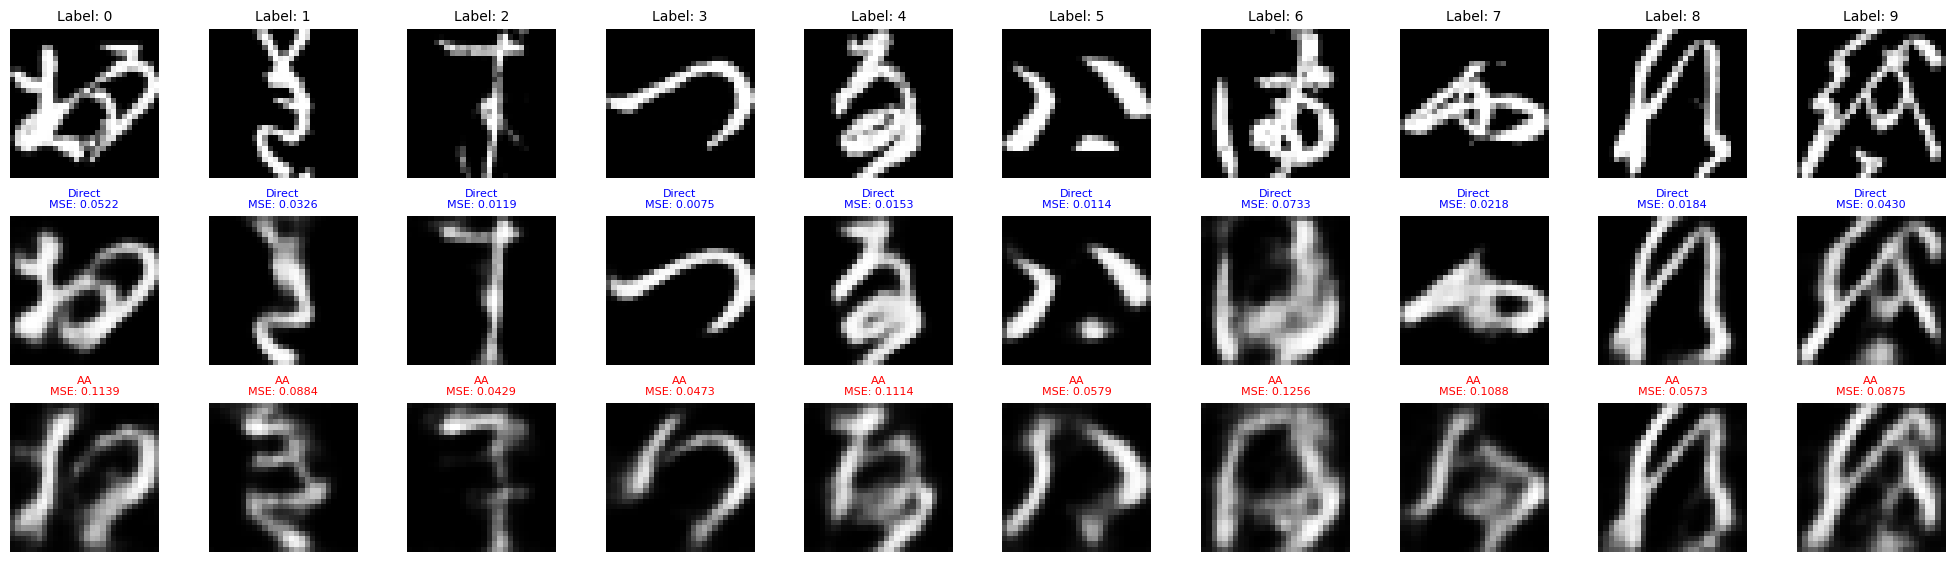

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import os

def visualize_digits_grid(exp_dir="./results/mnist_notebook_seed42_aa5", dataset="mnist"):
    """
    Display 10 digits (0–9), one per column:
    Row 1: Original image
    Row 2: VAE reconstruction
    Row 3: AA reconstruction
    Each column shows the label and the two MSE values.
    The first sample of each label from the training set is used.
    """
    transform = transforms.Compose([transforms.ToTensor()])
    if dataset == "mnist":
        ds_train = datasets.MNIST("./data", train=True, transform=transform, download=True)
    elif dataset == "kmnist":
        ds_train = datasets.KMNIST("./data", train=True, transform=transform, download=True)
    else:
        raise ValueError("dataset only mnist/kmnist")

    decoded_mu = np.load(os.path.join(exp_dir, "decoded_mu.npy"))
    decoded_mu_AA = np.load(os.path.join(exp_dir, "decoded_mu_AA.npy"))

    imgs = np.stack([img.numpy() for img, _ in ds_train])
    labels = np.array([lbl for _, lbl in ds_train])

    selected_idxs = [np.where(labels == d)[0][0] for d in range(10)]

    fig, axes = plt.subplots(3, 10, figsize=(20, 6))

    for col, idx in enumerate(selected_idxs):
        lbl = labels[idx]
        orig = imgs[idx, 0]
        recon = decoded_mu[idx, 0]
        aa_recon = decoded_mu_AA[idx, 0]

        mse_direct = np.mean((recon - orig) ** 2)
        mse_aa = np.mean((aa_recon - orig) ** 2)

        axes[0, col].imshow(orig, cmap="gray")
        axes[0, col].set_title(f"Label: {lbl}", fontsize=10)
        axes[0, col].axis("off")

        axes[1, col].imshow(recon, cmap="gray")
        axes[1, col].set_title(f"Direct\nMSE: {mse_direct:.4f}", fontsize=8, color="blue")
        axes[1, col].axis("off")

        axes[2, col].imshow(aa_recon, cmap="gray")
        axes[2, col].set_title(f"AA\nMSE: {mse_aa:.4f}", fontsize=8, color="red")
        axes[2, col].axis("off")

    # fig.suptitle("Digits 0–9: Original / Direct Reconstruction / AA Reconstruction", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


visualize_digits_grid(
    exp_dir="./results/kmnist_notebook_seed42_aa5",
    dataset="kmnist"
)


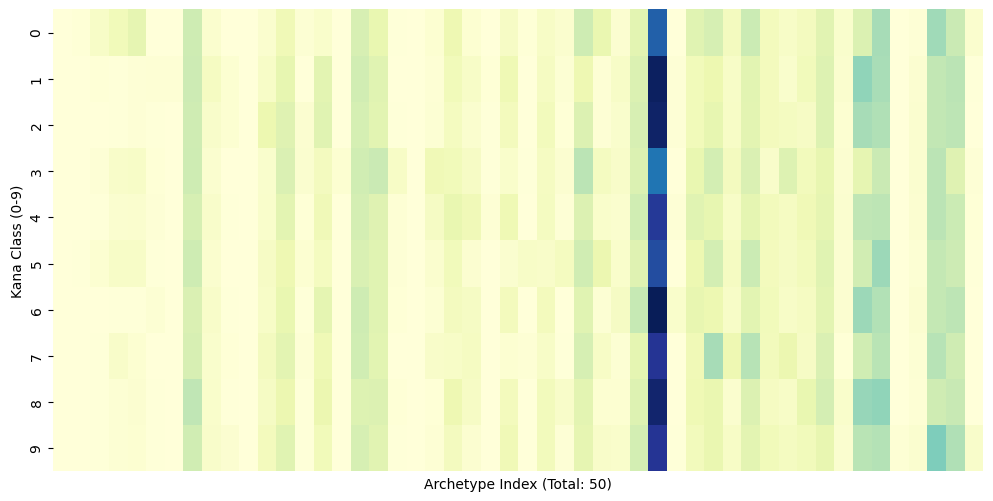

✅ 热力图绘制完成（仅使用保存的npy结果文件）。


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
import os

def visualize_classwise_aa_usage(exp_dir="./results/kmnist_notebook_seed42_aa5"):
    """
    Plot the KMNIST class–archetype heatmap using only the saved .npy files
    (with the corrected pseudo-inverse weight computation).
    """
    mu_aa = np.load(os.path.join(exp_dir, "latent_mu_AA.npy"))
    arch = np.load(os.path.join(exp_dir, "final_archetypes.npy"))

    arch_pinv = np.linalg.pinv(arch) 
    W_est = mu_aa @ arch_pinv         
    W_est = np.clip(W_est, 1e-8, None)  
    W_est /= W_est.sum(axis=1, keepdims=True)  

    transform = transforms.Compose([transforms.ToTensor()])
    ds = datasets.KMNIST("./data", train=True, download=True, transform=transform)
    y = np.array([label for _, label in ds]) 

    num_classes = 10
    heatmap_data = np.zeros((num_classes, W_est.shape[1]))  # [10, 50]
    for c in range(num_classes):
        heatmap_data[c] = W_est[y == c].mean(axis=0)

    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, cmap="YlGnBu", xticklabels=False,cbar=False)
    # plt.title("KMNIST Class-wise Archetype Usage")
    plt.xlabel("Archetype Index (Total: 50)")
    plt.ylabel("Kana Class (0-9)")
    plt.show()


visualize_classwise_aa_usage(exp_dir="./results/kmnist_notebook_seed42_aa5")


# Linear AA


All AA results saved to: ./results/kmnist_linear_AA
XC (latent archetypes): (32, 50)
S (weights): (50, 60000)
C (convex coefficients): (60000, 50)
A_global (decoded pixel archetypes): (50, 784)
SSE=966927.6764, variance explained=0.6931


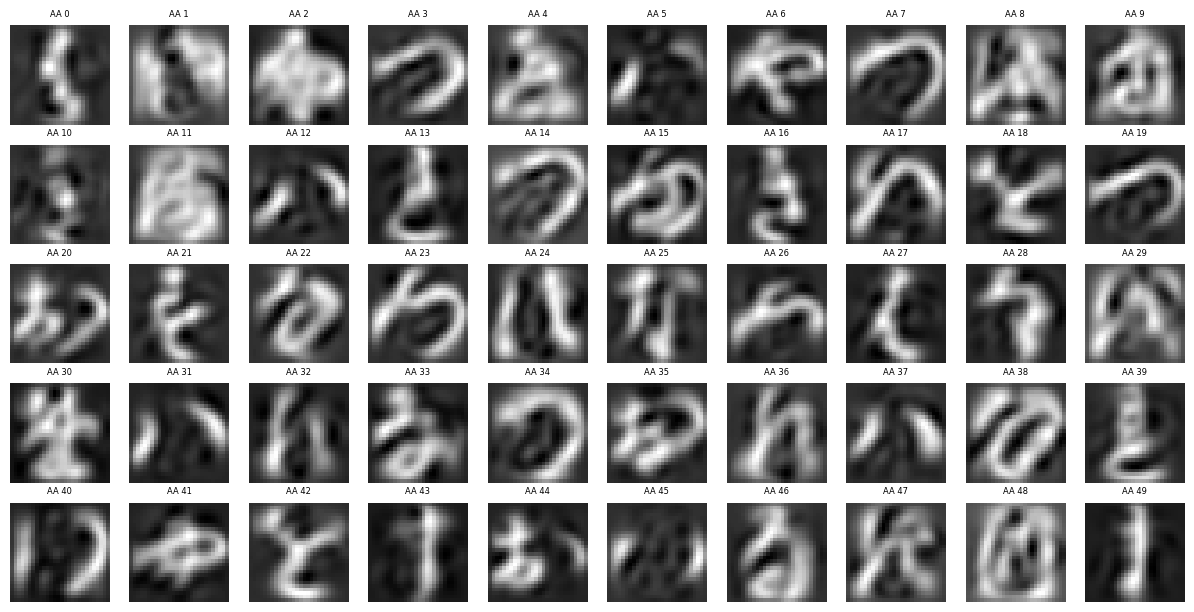

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from py_pcha import PCHA
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
import torch, random, warnings, os

# =========================
# Global Archetypal Analysis (PCA-32D)
# Based on PCA 32D latent space, performing global AA with convex hull constraint
# =========================

# ----------------------------
# Configuration
# ----------------------------
warnings.filterwarnings("ignore", category=UserWarning)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

save_dir = "./results/kmnist_linear_AA"
os.makedirs(save_dir, exist_ok=True)

# ----------------------------
# Load dataset (KMNIST)
# ----------------------------
transform = transforms.Compose([transforms.ToTensor()])
ds_train = datasets.KMNIST("./data", train=True, transform=transform, download=True)

X_train = np.array([img.numpy().flatten() for img, _ in ds_train])
y_train = np.array([label for _, label in ds_train])

# ----------------------------
# PCA dimensionality reduction
# ----------------------------
PCA_DIMS = 32
pca = PCA(n_components=PCA_DIMS, random_state=42)
Z_train = pca.fit_transform(X_train)

# ----------------------------
# Global AA training (PCHA)
# ----------------------------
N_ARCHETYPES = 50  # Total number of archetypes (equivalent to 5 per class × 10 classes)
XC, S, C, SSE, varexpl = PCHA(
    X=Z_train.T, noc=N_ARCHETYPES, maxiter=1000, verbose=False
)

# ----------------------------
# Decode archetypes back to pixel space
# ----------------------------
A_global = pca.inverse_transform(XC.T)

# ----------------------------
# Save all results
# ----------------------------
np.save(os.path.join(save_dir, "A_global.npy"), A_global)
np.save(os.path.join(save_dir, "Z_train.npy"), Z_train)
np.save(os.path.join(save_dir, "XC_latent.npy"), XC)
np.save(os.path.join(save_dir, "S_coeff.npy"), S)
np.save(os.path.join(save_dir, "C_coeff.npy"), C)
np.save(os.path.join(save_dir, "SSE.npy"), np.array([SSE]))
np.save(os.path.join(save_dir, "varexpl.npy"), np.array([varexpl]))
np.save(os.path.join(save_dir, "labels.npy"), y_train)

print("All AA results saved to:", save_dir)
print(f"XC (latent archetypes): {XC.shape}")
print(f"S (weights): {S.shape}")
print(f"C (convex coefficients): {C.shape}")
print(f"A_global (decoded pixel archetypes): {A_global.shape}")
print(f"SSE={SSE:.4f}, variance explained={varexpl:.4f}")

# ----------------------------
# Visualization
# ----------------------------
n_cols = 10
n_rows = N_ARCHETYPES // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.2, n_rows * 1.2))

for i, ax in enumerate(axes.flat):
    if i < N_ARCHETYPES:
        img = A_global[i].reshape(28, 28)
        ax.imshow(img, cmap="gray")
        ax.set_title(f"AA {i}", fontsize=6)
    ax.set_axis_off()

plt.tight_layout(pad=0.3, h_pad=0.4, w_pad=0.2)
plt.show()  # Display the figure directly instead of saving


In [32]:
import joblib
from sklearn.decomposition import PCA
import numpy as np
from torchvision import datasets, transforms

# ----------------------------
# Reload MNIST pixel data
# ----------------------------
transform = transforms.Compose([transforms.ToTensor()])
ds_train = datasets.KMNIST("./data", train=True, transform=transform, download=True)
X_pixel = np.array([img.numpy().flatten() for img, _ in ds_train])

# ----------------------------
# Rebuild PCA using the same parameters
# ----------------------------
pca = PCA(n_components=32, random_state=42)
pca.fit(X_pixel)

# ----------------------------
# Save PCA model
# ----------------------------
save_path = "./results/kmnist_linear_AA/pca_model.pkl"
joblib.dump(pca, save_path)
print(f" PCA model saved successfully at: {save_path}")


 PCA model saved successfully at: ./results/kmnist_linear_AA/pca_model.pkl


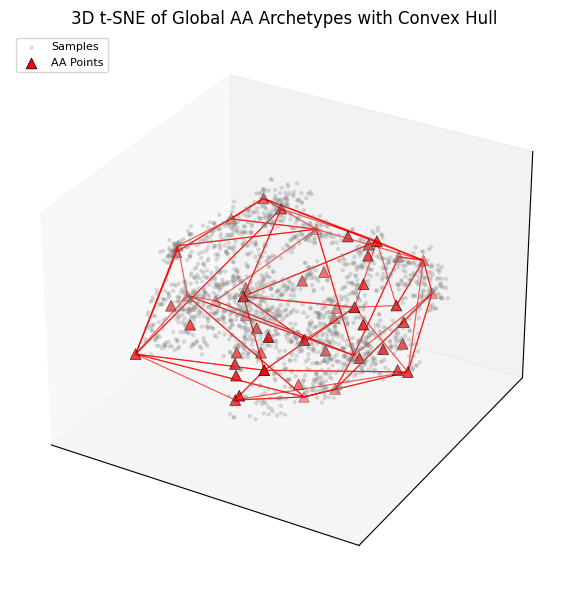

In [33]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
import numpy as np
import matplotlib.pyplot as plt

def visualize_tsne_pca_global_aa_hull(Z_train, y_train, A_global, pca, n_samples=2000):
    """
    Visualize 3D t-SNE of PCA latent space and Global Archetypal Analysis (AA) convex hull.
    """
    np.random.seed(42)

    # Randomly sample a subset of the training data
    idx = np.random.choice(len(Z_train), min(n_samples, len(Z_train)), replace=False)
    Z_sample = np.asarray(Z_train[idx])
    y_sample = np.asarray(y_train[idx])

    # Project archetypes into PCA latent space
    arch_all = np.asarray(pca.transform(np.asarray(A_global)))

    # Combine data and archetypes for joint t-SNE embedding
    Z_joint = np.vstack([Z_sample, arch_all])
    tsne = TSNE(n_components=3, init="pca", random_state=42, perplexity=30)
    Z_emb = tsne.fit_transform(Z_joint)
    Z_emb_data = Z_emb[:len(Z_sample)]
    Z_emb_aa = Z_emb[len(Z_sample):]

    # Compute convex hull from archetype points
    hull = ConvexHull(Z_emb_aa)

    # Create 3D figure
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot sample points (light gray)
    ax.scatter(Z_emb_data[:, 0], Z_emb_data[:, 1], Z_emb_data[:, 2],
               s=5, alpha=0.2, color='gray', label='Samples')

    # Plot archetype points (red triangles)
    ax.scatter(Z_emb_aa[:, 0], Z_emb_aa[:, 1], Z_emb_aa[:, 2],
               marker='^', s=60, color='red', edgecolors='k', linewidths=0.5, label='AA Points')

    # Plot convex hull edges
    for simplex in hull.simplices:
        pts = Z_emb_aa[simplex]
        ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], 'r-', linewidth=0.8, alpha=0.7)

    # Aesthetic adjustments
    ax.set_title("3D t-SNE of Global AA Archetypes with Convex Hull", fontsize=12)
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(False)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    plt.tight_layout()
    plt.show()


# Example call
visualize_tsne_pca_global_aa_hull(Z_train, y_train, A_global, pca, n_samples=2000)


In [34]:
import numpy as np
import joblib
import os

# =========================
# Load saved results
# =========================
save_dir = "./results/kmnist_linear_AA"
pca = joblib.load(f"{save_dir}/pca_model.pkl")
Z_train = np.load(f"{save_dir}/Z_train.npy")      # (60000, 32)
y_train = np.load(f"{save_dir}/labels.npy")
A_global = np.load(f"{save_dir}/A_global.npy")    # (50, 784)
XC = np.load(f"{save_dir}/XC_latent.npy")         # (32, 50)
S = np.load(f"{save_dir}/S_coeff.npy")            # (50, 60000)

# =========================
# Recalculate from original KMNIST images
# =========================
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor()])
ds_train = datasets.KMNIST("./data", train=True, transform=transform, download=True)
X_train = np.array([img.numpy().flatten() for img, _ in ds_train])  # Original pixel space (60000, 784)

# =========================
# Ensure correct matrix shapes
# =========================
if XC.shape[0] != Z_train.shape[1]:
    XC = XC.T
if S.shape[1] != X_train.shape[0]:
    S = S.T  # (60000, 50)

# =========================
# PCA reconstruction
# =========================
Z_pca = pca.transform(X_train)
X_pca_rec = pca.inverse_transform(Z_pca)

# =========================
# AA reconstruction
# =========================
Z_rec = (XC @ S).T  # (60000, 32)
X_aa_rec = pca.inverse_transform(Z_rec)

# =========================
# Compute MSE in pixel space
# =========================
mse_pca = ((X_train - X_pca_rec) ** 2).mean(axis=1)
mse_aa  = ((X_train - X_aa_rec)  ** 2).mean(axis=1)

# =========================
# Summarize per class
# =========================
results = {
    int(c): {"PCA": mse_pca[y_train == c].mean(), "AA": mse_aa[y_train == c].mean()}
    for c in np.unique(y_train)
}
results["ALL"] = {"PCA": mse_pca.mean(), "AA": mse_aa.mean()}

# =========================
# Output comparison
# =========================
print("\n==== PCA vs AA Reconstruction MSE (Pixel Space) ====")
for c in sorted([k for k in results.keys() if isinstance(k, (int, np.integer))]):
    print(f"Class {c}: PCA={results[c]['PCA']:.6f} | AA={results[c]['AA']:.6f}")
print(f"ALL: PCA={results['ALL']['PCA']:.6f} | AA={results['ALL']['AA']:.6f}")
print("====================================================")



==== PCA vs AA Reconstruction MSE (Pixel Space) ====
Class 0: PCA=0.045036 | AA=0.067314
Class 1: PCA=0.040711 | AA=0.058984
Class 2: PCA=0.037600 | AA=0.055989
Class 3: PCA=0.042036 | AA=0.061977
Class 4: PCA=0.047701 | AA=0.075244
Class 5: PCA=0.029361 | AA=0.046001
Class 6: PCA=0.039097 | AA=0.059357
Class 7: PCA=0.046465 | AA=0.070064
Class 8: PCA=0.042730 | AA=0.059724
Class 9: PCA=0.049193 | AA=0.070830
ALL: PCA=0.041993 | AA=0.062548


✔ XC shape: (32, 50), S shape: (50, 60000)


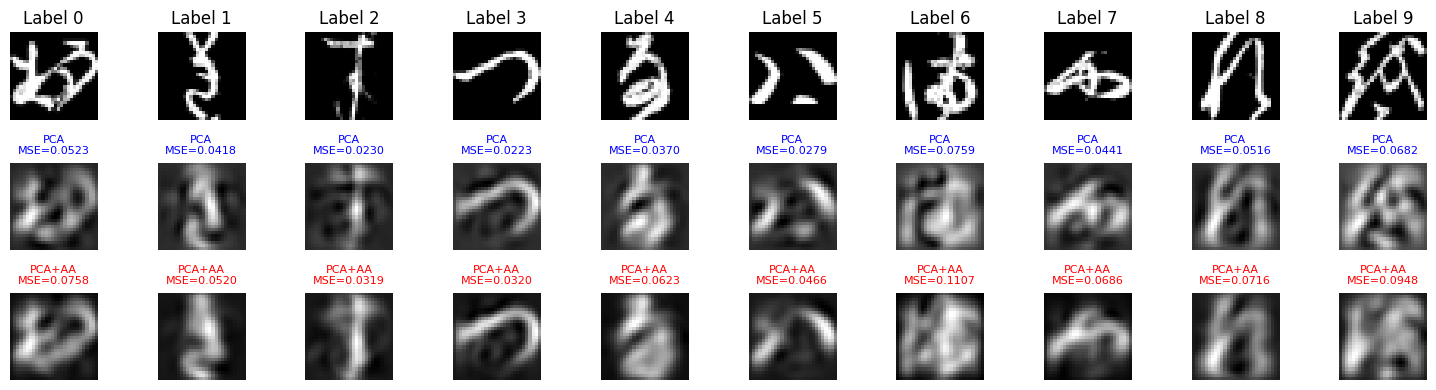

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# =========================
# Load saved results
# =========================
save_dir = "./results/kmnist_linear_AA"
pca = joblib.load(f"{save_dir}/pca_model.pkl")
A_global = np.load(f"{save_dir}/A_global.npy")
XC = np.load(f"{save_dir}/XC_latent.npy")     # (32, 50): latent archetypes (columns are archetypes)
S = np.load(f"{save_dir}/S_coeff.npy")        # (50, 60000): PCHA weights (rows are archetype weights)

# =========================
# Load MNIST training data
# =========================
transform = transforms.Compose([transforms.ToTensor()])
ds_train = datasets.KMNIST("./data", train=True, transform=transform, download=True)
X_train = np.array([img.numpy().flatten() for img, _ in ds_train])
y_train = np.array([label for _, label in ds_train])

# =========================
# Select one example per digit
# =========================
selected_idxs = [np.where(y_train == i)[0][0] for i in range(10)]
X_selected = X_train[selected_idxs]
y_selected = y_train[selected_idxs]

# =========================
# Ensure correct dimensions (critical for proper PCHA reconstruction)
# =========================
# S should have shape: (N_ARCHETYPES, N_SAMPLES) = (50, 60000)
if S.shape[0] != 50:  # If S was transposed earlier, fix to (50, 60000)
    S = S.T
# XC should have shape: (PCA_DIMS, N_ARCHETYPES) = (32, 50)
if XC.shape[1] != 50:  # If XC has wrong orientation, fix it
    XC = XC.T

print(f"✔ XC shape: {XC.shape}, S shape: {S.shape}")  # Expected (32, 50) and (50, 60000)

# =========================
# PCA encoding and reconstruction
# =========================
Z_selected = pca.transform(X_selected)
X_pca_rec = pca.inverse_transform(Z_selected)

# =========================
# AA reconstruction (correct matrix order)
# =========================
S_selected = S[:, selected_idxs]  # Select weights for chosen samples: (50, 10)
Z_rec_AA = XC @ S_selected        # (32, 50) @ (50, 10) = (32, 10) → latent reconstruction
Z_rec_AA = Z_rec_AA.T             # Transpose to (10, 32) for PCA inverse transform
X_AA_rec = pca.inverse_transform(Z_rec_AA)

# =========================
# Visualization: Original / PCA / PCA→AA
# =========================
fig, axes = plt.subplots(3, 10, figsize=(15, 4))
for i in range(10):
    mse_pca = np.mean((X_pca_rec[i] - X_selected[i]) ** 2)
    mse_aa = np.mean((X_AA_rec[i] - X_selected[i]) ** 2)

    axes[0, i].imshow(X_selected[i].reshape(28, 28), cmap="gray")
    axes[0, i].set_title(f"Label {y_selected[i]}")
    axes[1, i].imshow(X_pca_rec[i].reshape(28, 28), cmap="gray")
    axes[1, i].set_title(f"PCA\nMSE={mse_pca:.4f}", fontsize=8, color="blue")
    axes[2, i].imshow(X_AA_rec[i].reshape(28, 28), cmap="gray")
    axes[2, i].set_title(f"PCA+AA\nMSE={mse_aa:.4f}", fontsize=8, color="red")

    for j in range(3):
        axes[j, i].axis("off")

# fig.suptitle("Original / PCA Reconstruction / PCA→AA Reconstruction", fontsize=12)
plt.tight_layout()
plt.show()


# AE-AA

https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1010025

Non-linear archetypal analysis of single-cell RNA-seq data by deep autoencoders

In [25]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import random
import numpy as np
from sklearn.cluster import KMeans
import os 
import json 
import pickle 
import sys

# ----------------------------
# Config
SEED = 42
def set_seed(s=SEED):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Init] Using device: {device}")

batch_size = 500
max_epochs = 50
latent_dim = 32
lr = 5e-3
train_subset_size = 20000
warmup_epochs = 5
semantic_epochs = 10

nu_x_tilde = 300
gamma = 1
beta = 0.01
cos_sim_weight = 1.0

num_archetypes_per_class = 5
num_classes = 10
total_archetypes = num_archetypes_per_class * num_classes

EXP_DIR = "./results/kmnist_ae_seed42_aa5"
os.makedirs(EXP_DIR, exist_ok=True)

# ----------------------------
# Data 
transform = transforms.Compose([transforms.ToTensor()])
full_train_set = datasets.KMNIST("./data", train=True, download=True, transform=transform)
test_set = datasets.KMNIST("./data", train=False, download=True, transform=transform)

img_channels, img_size = 1, 28

train_loader_full = DataLoader(full_train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

def prepare_class_full_data(full_train_set, device):
    class_full_imgs = {}
    for img, label in full_train_set:
        label = int(label)
        if label not in class_full_imgs:
            class_full_imgs[label] = []
        class_full_imgs[label].append(img.unsqueeze(0))
    for label in class_full_imgs:
        class_full_imgs[label] = torch.cat(class_full_imgs[label]).to(device)
    return class_full_imgs

class_full_imgs = prepare_class_full_data(full_train_set, device)

# ----------------------------
# Model
class AEWithAA(torch.nn.Module):
    def __init__(self, latent_dim=32, img_channels=1, img_size=28, num_classes=10):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 3, stride=2, padding=1), torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 3, stride=2, padding=1), torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(7 * 7 * 64, 512), torch.nn.ReLU(),
            torch.nn.Linear(512, latent_dim)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 512), torch.nn.ReLU(),
            torch.nn.Linear(512, 7 * 7 * 64),
            torch.nn.Unflatten(1, (64, 7, 7)),
            torch.nn.ConvTranspose2d(64, 32, 4, 2, 1), torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 1, 4, 2, 1), torch.nn.Sigmoid()
        )
        self.arch_logits = torch.nn.ParameterDict()
        self.class_full_mu = {}
        self.fc_sample_to_aa = torch.nn.Linear(latent_dim, total_archetypes)

    def encode(self, x):
        h = self.encoder(x)
        mu = h / (h.norm(dim=1, keepdim=True) + 1e-8)
        return mu

    def decode(self, z):
        return self.decoder(z)

    def init_class_archetypes(self, class_full_imgs, device):
        print("[Init] Initializing archetypes for all classes...")
        self.eval()
        for label, imgs in class_full_imgs.items():
            mu = self.encode(imgs)
            self.class_full_mu[label] = mu.detach()
            mu_np = mu.detach().cpu().numpy()
            km = KMeans(n_clusters=num_archetypes_per_class, random_state=SEED, n_init=10).fit(mu_np)
            centers = torch.tensor(km.cluster_centers_, device=device, dtype=mu.dtype)
            dists = torch.cdist(centers, mu)
            idx = dists.topk(k=20, largest=False).indices
            logits = torch.zeros(num_archetypes_per_class, mu.size(0), device=device)
            for i in range(num_archetypes_per_class):
                logits[i, idx[i]] = 5.0
            self.arch_logits[str(label)] = torch.nn.Parameter(logits, requires_grad=True)
        print("[Init] Archetypes (logits) initialized successfully!")
        self.train()

    def get_all_archetypes(self):
        all_arch = []
        for label in sorted(self.arch_logits.keys()):
            W = F.softmax(self.arch_logits[label], dim=1)
            X_mu_full = self.class_full_mu[int(label)]
            all_arch.append(W @ X_mu_full)
        return torch.cat(all_arch, dim=0)

    def forward(self, x):
        mu = self.encode(x)
        z = mu
        sample_to_aa_weights = F.softmax(self.fc_sample_to_aa(mu), dim=1)
        x_hat = self.decode(z)
        return x_hat, z, mu, torch.zeros(1).to(device), torch.zeros(1).to(device), sample_to_aa_weights

# ----------------------------
# Loss functions 
def kl_loss(mu, logvar): return torch.tensor(0.0).to(mu.device)
def recon_loss(x_hat, x): return F.mse_loss(x_hat, x, reduction='mean')

def cos_similarity_loss(mu_batch, all_archetypes, weights_batch):
    recon_sample = torch.matmul(weights_batch, all_archetypes)
    cos_sim = F.cosine_similarity(recon_sample, mu_batch, dim=1).mean()
    return (1 - cos_sim)

def total_aa_loss(model, mu, y):
    all_archetypes = model.get_all_archetypes()
    weights_batch = F.softmax(model.fc_sample_to_aa(mu), dim=1)
    recon_sample = torch.matmul(weights_batch, all_archetypes)
    loss_sample = F.mse_loss(recon_sample, mu)
    loss_cos = cos_similarity_loss(mu, all_archetypes, weights_batch)
    total_loss = loss_sample + cos_sim_weight * loss_cos
    return total_loss, loss_sample.item(), loss_cos.item()

# ----------------------------
# Training
def compute_epoch_losses(model, loader, device, is_train, optimizer=None, epoch=0):
    model.train() if is_train else model.eval()
    total_I_tx = total_I_ty = total_recon = total_AA = total_total = 0.0
    total_samples = 0
    use_aa_beta = (epoch >= semantic_epochs)
    epoch_total_loss_list = []
    with torch.set_grad_enabled(is_train):
        for batch_idx, (x, y) in enumerate(loader):
            x, y = x.to(device), y.to(device)
            x_hat, z, mu, _, _, _ = model(x)
            I_tx = kl_loss(mu, None)
            recon = recon_loss(x_hat, x)
            I_ty_display = 0.0
            if use_aa_beta:
                L_at, avg_Ls, avg_La = total_aa_loss(model, mu, y)
            else:
                L_at, avg_Ls, avg_La = torch.tensor(0.0).to(device), 0.0, 0.0
            total_loss = I_tx + nu_x_tilde * recon
            if use_aa_beta:
                total_loss += gamma * L_at
            if is_train:
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()
            bs = x.size(0)
            total_I_tx += I_tx.item() * bs
            total_recon += recon.item() * bs
            total_AA += L_at.item() * bs
            total_total += total_loss.item() * bs
            total_samples += bs
            epoch_total_loss_list.append(total_loss.item())
            if (batch_idx + 1) % 10 == 0:
                sys.stdout.write(f"[Train] Batch {batch_idx+1:03d} | Recon: {recon.item():.4f} | Total: {total_loss.item():.4f}\n")
                if use_aa_beta:
                    sys.stdout.write(f"   ↳ AA sample loss: {avg_Ls:.6f} | AA cos loss: {avg_La:.6f}\n")
                sys.stdout.flush()
    avg_total = total_total / total_samples
    return avg_total, epoch_total_loss_list

# ----------------------------
# Main
# ----------------------------
if __name__ == "__main__":
    model = AEWithAA(latent_dim=latent_dim, img_channels=img_channels, img_size=img_size, num_classes=num_classes).to(device)
    optimizer = torch.optim.Adam([{"params": model.parameters(), "lr": lr}])
    epoch_losses = []

    print(f"[Training Start] {max_epochs} epochs total")
    print(f"Results will be saved to: {EXP_DIR}")

    for epoch in range(max_epochs):
        use_aa_beta = (epoch >= semantic_epochs)
        print(f"===================== Epoch {epoch+1}/{max_epochs} =====================")
        if epoch < semantic_epochs:
            print("Mode: Warmup/Reconstruction only")
        else:
            print("Mode: Full (Recon + AA-MSE + AA-Cos)")

        rand_idx = random.sample(range(len(full_train_set)), train_subset_size)
        train_subset = Subset(full_train_set, rand_idx)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

        if epoch == semantic_epochs:
            model.init_class_archetypes(class_full_imgs, device)
            for p in model.arch_logits.parameters():
                p.requires_grad = True
            optimizer.add_param_group({"params": model.arch_logits.parameters(), "lr": 1e-2})

        avg_total, epoch_total_loss_list = compute_epoch_losses(model, train_loader, device, True, optimizer, epoch)
        epoch_losses.append(avg_total)
        print(f"\n[Summary] Epoch {epoch+1} Train Total Loss: {avg_total:.4f}")
        print("=======================================================================\n")


    loss_path = os.path.join(EXP_DIR, "epoch_total_losses.pkl")
    with open(loss_path, "wb") as f:
        pickle.dump(epoch_losses, f)
    print(f"[Save] Epoch losses saved to: {loss_path}")

    torch.save(model.state_dict(), os.path.join(EXP_DIR, "model_final.pth"))
    torch.save(model, os.path.join(EXP_DIR, "model_full.pth"))
    print(f"[Save] Final model saved to: {EXP_DIR}")

    if hasattr(model, "get_all_archetypes"):
        all_arch = model.get_all_archetypes().cpu().detach().numpy()
        np.save(os.path.join(EXP_DIR, "final_archetypes.npy"), all_arch)
        decoded = model.decode(model.get_all_archetypes().to(device)).cpu().detach().numpy()
        np.save(os.path.join(EXP_DIR, "final_archetypes_decoded.npy"), decoded)
        print(f"[Save] Archetypes & decoded saved to: {EXP_DIR}")

    print("\n[PostProcess] Saving full latent reconstruction results ...")
    full_loader = DataLoader(full_train_set, batch_size=batch_size, shuffle=False)
    model.eval()
    all_mu, all_mu_aa, all_decoded_mu, all_decoded_mu_aa, all_mse = [], [], [], [], []
    with torch.no_grad():
        all_archetypes = model.get_all_archetypes().to(device)
        for x, _ in full_loader:
            x = x.to(device)
            mu = model.encode(x)
            weights = F.softmax(model.fc_sample_to_aa(mu), dim=1)
            mu_aa = weights @ all_archetypes
            decoded_mu = model.decode(mu)
            decoded_mu_aa = model.decode(mu_aa)
            mse = F.mse_loss(decoded_mu_aa, x, reduction="none").mean(dim=[1, 2, 3])
            all_mu.append(mu.cpu())
            all_mu_aa.append(mu_aa.cpu())
            all_decoded_mu.append(decoded_mu.cpu())
            all_decoded_mu_aa.append(decoded_mu_aa.cpu())
            all_mse.append(mse.cpu())

    np.save(os.path.join(EXP_DIR, "latent_mu.npy"), torch.cat(all_mu).numpy())
    np.save(os.path.join(EXP_DIR, "latent_mu_AA.npy"), torch.cat(all_mu_aa).numpy())
    np.save(os.path.join(EXP_DIR, "decoded_mu.npy"), torch.cat(all_decoded_mu).numpy())
    np.save(os.path.join(EXP_DIR, "decoded_mu_AA.npy"), torch.cat(all_decoded_mu_aa).numpy())
    np.save(os.path.join(EXP_DIR, "reconstruction_mse.npy"), torch.cat(all_mse).numpy())

    mean_mse = torch.cat(all_mse).mean().item()
    with open(os.path.join(EXP_DIR, "reconstruction_mse_mean.txt"), "w") as f:
        f.write(f"Average MSE (AA reconstruction): {mean_mse:.6f}\n")
    print(f"[Done] AA reconstruction results saved to: {EXP_DIR}")
    print(f"Average AA reconstruction MSE = {mean_mse:.6f}")


[Init] Using device: cpu
[Training Start] 50 epochs total
Results will be saved to: ./results/kmnist_ae_seed42_aa5
===================== Epoch 1/50 =====================
Mode: Warmup/Reconstruction only
[Train] Batch 010 | Recon: 0.1141 | Total: 34.2209
[Train] Batch 020 | Recon: 0.1076 | Total: 32.2949
[Train] Batch 030 | Recon: 0.1025 | Total: 30.7569
[Train] Batch 040 | Recon: 0.0951 | Total: 28.5289

[Summary] Epoch 1 Train Total Loss: 34.4964

===================== Epoch 2/50 =====================
Mode: Warmup/Reconstruction only
[Train] Batch 010 | Recon: 0.0935 | Total: 28.0466
[Train] Batch 020 | Recon: 0.0907 | Total: 27.2174
[Train] Batch 030 | Recon: 0.0896 | Total: 26.8670
[Train] Batch 040 | Recon: 0.0860 | Total: 25.7905

[Summary] Epoch 2 Train Total Loss: 27.4954

===================== Epoch 3/50 =====================
Mode: Warmup/Reconstruction only
[Train] Batch 010 | Recon: 0.0803 | Total: 24.1045
[Train] Batch 020 | Recon: 0.0760 | Total: 22.7883
[Train] Batch 030 |

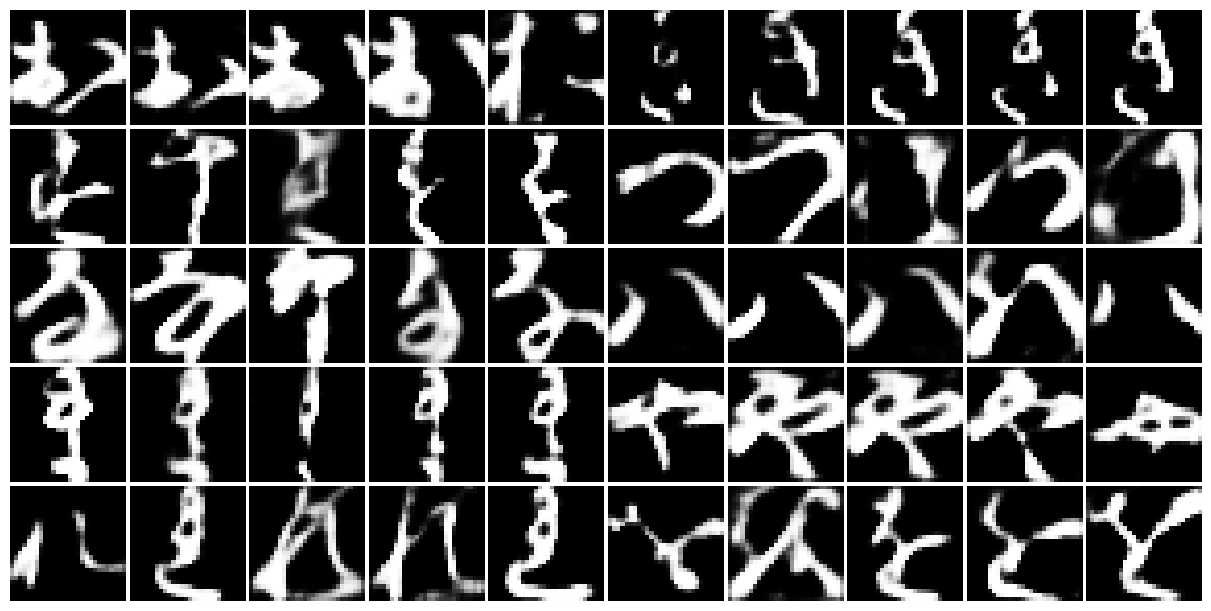

In [5]:
from utils.visualization import plot_decoded_archetypes
plot_decoded_archetypes("results/kmnist_ae_seed42_aa5")

[Step 1/3] Reducing 32D latent space to 3D using t-SNE...


c:\Users\mingx\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[Step 2/3] Computing convex hull for 50 archetypes...
[Step 3/3] Plotting 3D latent space visualization...


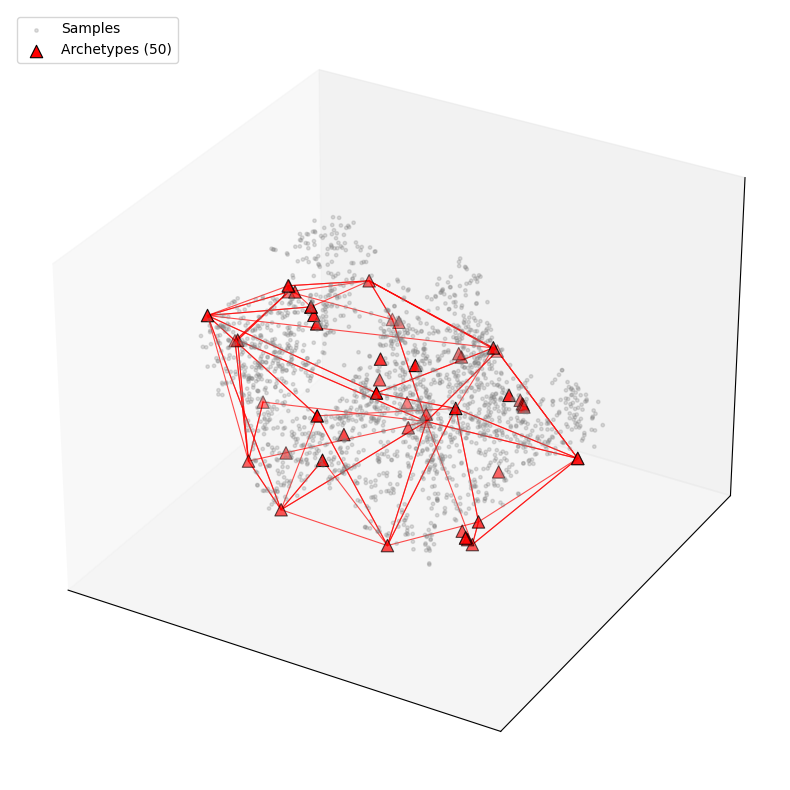

In [6]:
from utils.visualization import visualize_ae_latent_3d
visualize_ae_latent_3d(exp_dir="results/kmnist_ae_seed42_aa5", seed=42)

In [50]:
from utils.evaluation import evaluate_reconstruction_from_saved
evaluate_reconstruction_from_saved(exp_dir="./results/kmnist_ae_seed42_aa5", dataset="kmnist")


==== KMNIST Reconstruction MSE ====
Class 0: Direct=0.019458 | AA=0.072489
Class 1: Direct=0.017206 | AA=0.061386
Class 2: Direct=0.014100 | AA=0.059142
Class 3: Direct=0.014278 | AA=0.068388
Class 4: Direct=0.019891 | AA=0.081539
Class 5: Direct=0.008586 | AA=0.048558
Class 6: Direct=0.017521 | AA=0.070301
Class 7: Direct=0.021176 | AA=0.074225
Class 8: Direct=0.017545 | AA=0.061240
Class 9: Direct=0.019892 | AA=0.072149
Overall: Direct=0.016965 | AA=0.066942


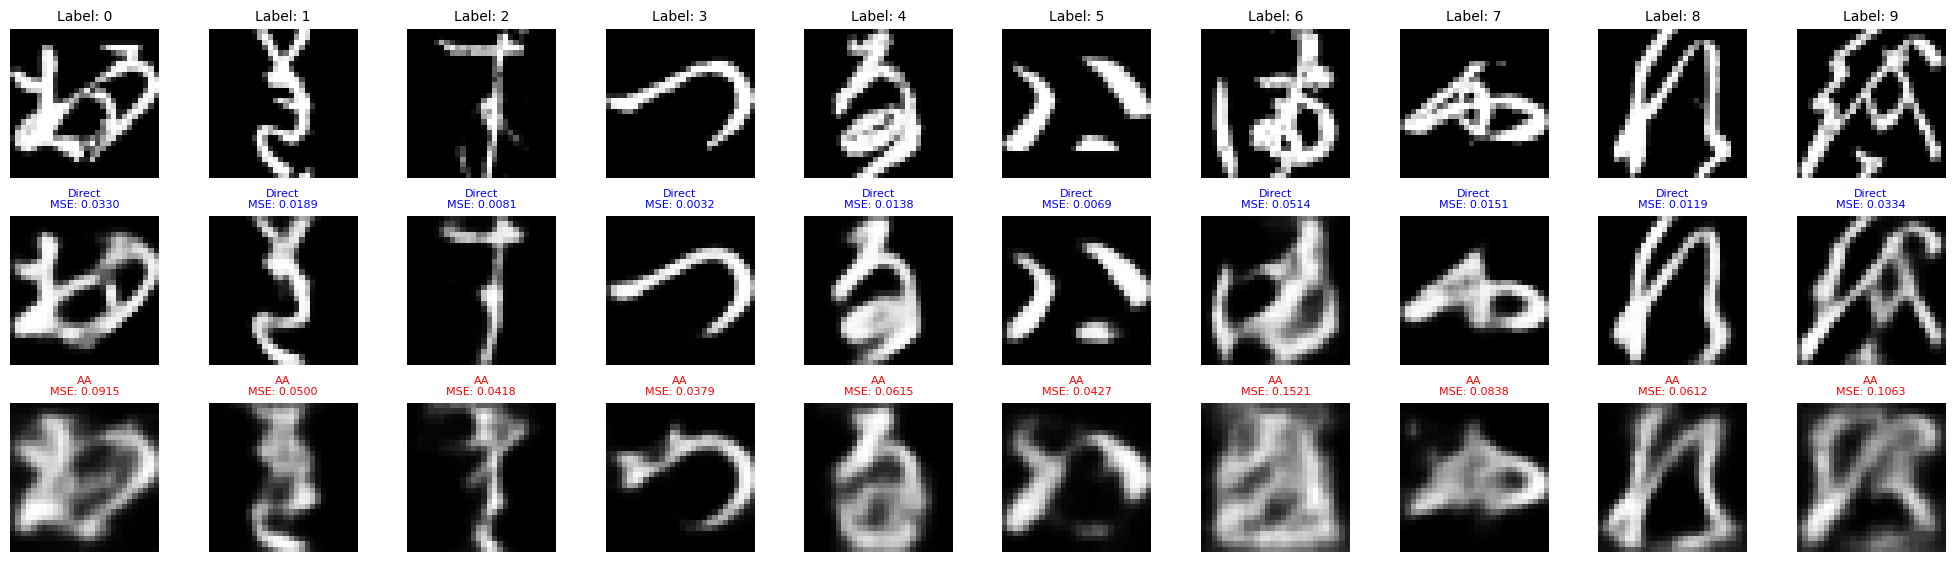

In [7]:
visualize_digits_grid(exp_dir="./results/kmnist_ae_seed42_aa5", dataset="kmnist")

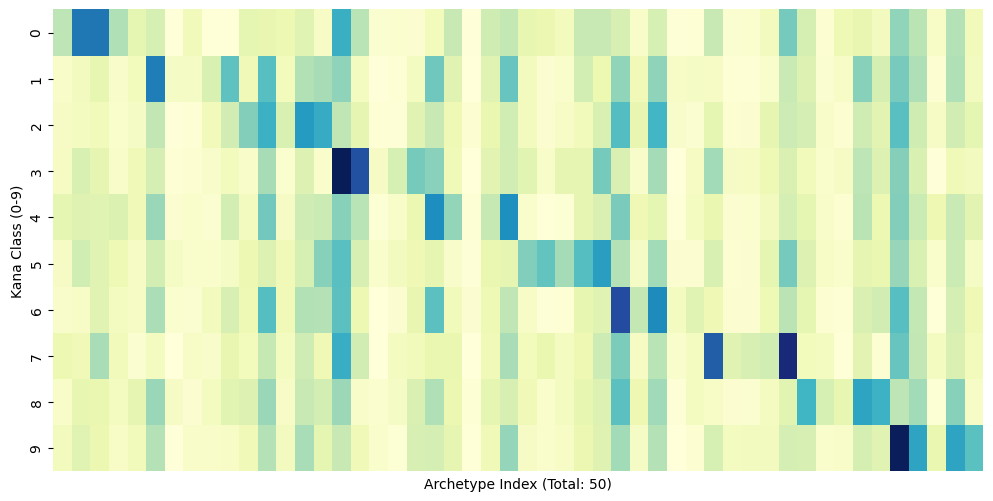

✅ 热力图绘制完成（仅使用保存的npy结果文件）。


In [8]:
visualize_classwise_aa_usage(exp_dir="./results/kmnist_ae_seed42_aa5")